# Spoken Digit Classification

## Imports

In [1]:
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import librosa
import scipy as sp

# Utility
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from IPython.display import Audio

# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder

# Scalers
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


## Dataset download

Here we are downloading the [dataset from the assignment](https://github.com/Jakobovski/free-spoken-digit-dataset) (N = 2000) along with a custom made dataset obtained from a subset of the [Google Speech Commands Dataset](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html) (N = 23666) for testing purposes.


In [2]:
! git clone -q https://github.com/Jakobovski/free-spoken-digit-dataset

os.environ['KAGGLE_USERNAME'] = "andreacoppola"
os.environ['KAGGLE_KEY'] = "8d841874df721c79c79ada9beec21904"
!kaggle datasets download -d andreacoppola/googlespokendigits
!unzip googlespokendigits.zip

100% 669M/669M [00:09<00:00, 84.5MB/s]
100% 669M/669M [00:09<00:00, 77.0MB/s]
Archive:  googlespokendigits.zip
  inflating: X_google_dataset.npy    
  inflating: Y_google_dataset.npy    


## Dataset import 

The informations about the audio track are retrieved from the name using the following regexp
```python
'([0-9]+)_([a-z]+)_([0-9]+).wav'
```
With this we can retrieve from the 3 groups
```python
# Digit Label
regexp.search(filename).group(1)
# Spearker Name (maybe we'll need this later while analyzing the data?)
regexp.search(filename).group(2)
# File Index
regexp.search(filename).group(3)
```


In [3]:
# recordings directory
directory = 'free-spoken-digit-dataset/recordings/'
# regexp matching {digitLabel}_{speakerName}_{index}.wav
regexp = re.compile('([0-9]+)_([a-z]+)_([0-9]+).wav') 

labels  = []
audios  = []
indexes = []
sizes   = []
names   = []

# setup progress bar
pbar = tqdm(desc='Loading audio samples')
pbar.reset(total=len(os.listdir(directory))) 

for f in os.listdir(directory):
  if f.endswith(".wav"): 
    labels.append(regexp.search(f).group(1))       # Take the first group (label)
    names.append(regexp.search(f).group(2))        # Take the second groun (name)
    indexes.append(int(regexp.search(f).group(3))) # Take the last group (index)
    x, sr = librosa.load(directory+f, sr=None)     # Load audio file
    sizes.append(x.size)
    audios.append(x)                               # Put it in the list
  pbar.update()                                    # updates progress bar
pbar.refresh();

# python lists to np.ndarray
Y = np.asarray(labels)
X = np.asarray(audios)
I = np.asarray(indexes)

## Preprocessing



**Legend:**
  - Y are the label for the assignment dataset
  - X is the original dataset with tracks trimmed to be 1 second long at maximum to avoid unwantend noise
  - L is an X version in which every audio track with less than 8000 samples is zero padded to be 8000 samples long, so each track is 1 sec long
  - N and S are the names of the speakers and sizes
  - X_GD and Y_GD are respectively the Google Dataset's _audio tracks_ and _labels_


Each of the dataset test and train partitions can be obtaind by appending "_test" and "_train" on their name (except for the Google ones that are intended to be partitioned only if needed)


### Assignment Dataset

Here we are doing the trimming on X and extending the files that are over 8000 samples long to be 8000 sample long on L

In [4]:
'''
Create an array (L) of empty audio tracks of 8000 samples
For each audio track in X:
  if the track is too long, trim it to be 1 second long (8000 samples)
  Then fill the first
'''
# L is the trimmed and zero-padded dataset
L = np.zeros((X.size, 8000))
pbar = tqdm(desc='Zero Padding and trimming')
pbar.reset(total=len(X))
for i in range(len(X)):
  if(X[i].size>8000): X[i] = X[i][0:8000] 
  L[i, 0:X[i].size] = X[i]                 
  pbar.update();                             
pbar.refresh();

Here we're doing a train-test split using the conditions stated in the github repository

In [0]:
is_in_test  = I <= 4
is_in_train = I >  4

Y_test, Y_train = Y[is_in_test], Y[is_in_train]
L_test, L_train = L[is_in_test], L[is_in_train]  # Trimmed and zero-padded dataset
X_test, X_train = X[is_in_test], X[is_in_train]  # Original dataset

If needed we can extract the speaker name and sizes too.  
_(NB: the sizes was used for analysis purposes on the dataset and don't necessarily reflect the sizes used after the preprocessing step)_

In [0]:
N = np.asarray(names)
S = np.asarray(sizes)

N_test, N_train = N[is_in_test], N[is_in_train]
S_test, S_train = S[is_in_test], S[is_in_train]

### Google Dataset

Extraction of the spoken digits from the Google Dataset (please be careful, the label here is an integer and not a string!)

In [0]:
X_GD = np.load('X_google_dataset.npy', allow_pickle=True)
Y_GD = np.load('Y_google_dataset.npy', allow_pickle=True)

## Features

This is a series of functions we used to do classification tests

### MFCC

In [0]:
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=512,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=40,
        fmin=133,
        fmax=4000
    )

    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X)

    # Logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # DCT
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]

    return mfcc

### Zero Crossing Rate

In [0]:
'''
  Informations about windowing in order to not repeat them 
  everytime we compute a feature that needs to know the number and type of windows
'''
Fs=8000
win_length = int(np.floor(0.01 * Fs)) 
hop_size = int(np.floor(0.0075 * Fs))
audio_ref = L_test[1]
win_number = int(np.floor((audio_ref.shape[0] - win_length) / hop_size))
window = sp.signal.get_window(window='hanning', Nx=win_length)

def compute_zcr(audio, fs):
  zcr = np.zeros(win_number)
  for n in np.arange(win_number):
    frame = audio[n * hop_size : n * hop_size + win_length]
    frame_win = frame * window
    win_sign = np.sign(frame_win)
    N = np.shape(frame_win)[0]
    sign_diff = np.abs(win_sign[: -1] - win_sign[1 :])
    zcr[n] = (fs / 2*N) * np.sum(sign_diff) 
  return zcr

### Spectral Decrease

In [0]:
def compute_specdec(audio):
  spectral_decrease = np.zeros(win_number)
  for n in np.arange(win_number):
    frame = audio[n * hop_size : n * hop_size + win_length]
    frame_win = frame * window
    spec = np.fft.fft(frame_win)
    mul_fact = 1 / np.sum(np.abs(spec[1:]))
    num = np.abs(spec[1:]) - np.tile(A = np.abs(spec[0]), reps=len(spec))[1:]
    den = np.arange(1, len(spec)) - 1
    spectral_decrease[n] = mul_fact * np.sum(num / den)
  return spectral_decrease

### Spectral Centroid

In [0]:
def compute_speccentr(audio):
  speccentr = np.zeros(win_number)
  for n in np.arange(win_number):
    frame = audio[n * hop_size : n * hop_size + win_length]
    frame_win = frame * window
    spec = np.fft.fft(frame_win)
    k_axis = np.arange(spec.shape[0])
    speccentr[n] = np.sum(np.transpose(k_axis)*np.abs(spec)) / np.sum(np.abs(spec))
  return speccentr

## Classification


### Functions for classification

This function encapsulates the previous functions to compare the performances during the classification step

In [0]:
def feature_extraction(data, feat_type):
  size = len(data)
  
  pbar = tqdm(desc='Feature extracion... [{}]'.format(feat_type))
  pbar.reset(total=len(data))

  Fs = 8000
  features = None
  Z= data.copy()
  threshold_val = 0.1
  for i in range(len(Z)):
    Z_max = np.max(Z[i])
    Z_min = np.min(Z[i])
    conditions =  np.logical_and (Z[i]<Z_max*threshold_val, Z[i]>Z_min*threshold_val)
    Z[i][conditions] = 0 
   
  
  if(feat_type == "mfcc20"):
    n_mfcc = 20
    features = np.zeros((size, n_mfcc))
    for i in range(size):
      mfcc = compute_mfcc(data[i], Fs, n_mfcc)
      features[i, :] = np.mean(mfcc, axis=1)
      pbar.update()
    pbar.refresh()
  if(feat_type == "mfcc13"):
    n_mfcc = 13
    features = np.zeros((size, n_mfcc))
    for i in range(size):
      mfcc = compute_mfcc(data[i], Fs, n_mfcc)
      features[i, :] = np.mean(mfcc, axis=1)
      pbar.update()
    pbar.refresh()
  if(feat_type == "zcr"):
    features = np.zeros((size, win_number))
    for i in range(size):
      features[i, :] = compute_zcr(Z[i], Fs)
      pbar.update()
    pbar.refresh()
  if(feat_type == "specdec"): 
    features = np.zeros((size, win_number))
    for i in range(size):
      features[i, :] = compute_specdec(data[i])
      pbar.update()
    pbar.refresh()
  if(feat_type == "speccentr"): 
      features = np.zeros((size, win_number))
      for i in range(size):
        features[i, :] = compute_speccentr(data[i])
        pbar.update()
      pbar.refresh()
  if(feat_type == "zcr+mfcc20"):
      n_mfcc = 20
      features = np.zeros((size, n_mfcc + win_number +2)) 
      for i in range(size):
        features[i,0:n_mfcc] = np.mean(compute_mfcc(data[i], Fs, n_mfcc), axis=1)
        features[i,n_mfcc+1:-1] = compute_zcr(Z[i], Fs)
        pbar.update()
      pbar.refresh()  
  return features

Metrics to be used

In [0]:
def compute_metrics (y_pred, y_test):
  acc = accuracy_score(y_test, y_pred)
  cm  = confusion_matrix(y_test, y_pred)

  return [("Accuracy",acc), ("ConfusionMatrix",cm)]

### Feature extraction

In [29]:
#This are the features that we want to extract using the feature_extraction function
feature_methods = ["mfcc13", "mfcc20", "zcr", "zcr+mfcc20"]

classifiers = []
metrics_dict = {} # this will contain the metrics for each classifier and each feature
                  # EX: for classifier "foo" and feature "bar" metrics_dict["foo"]["bar"]

# Feature Extraction and Scaling
train_features_dict = {}

scalers_dict = {}
for fm in feature_methods:
  train_feature = feature_extraction(L_train, fm)

  scaler = MinMaxScaler()
  scaler.fit(train_feature)
  scaler.transform(train_feature)

  train_features_dict[fm] = train_feature
  scalers_dict[fm] = scaler

### Support Vector Machine

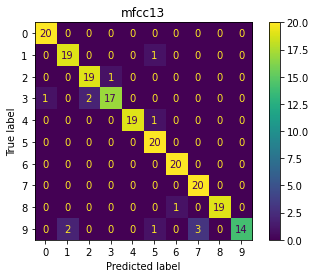

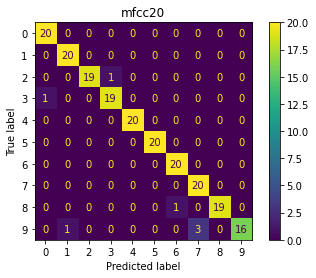

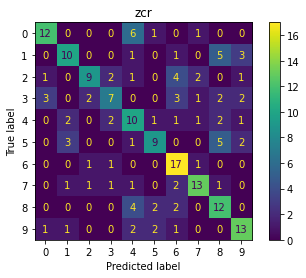

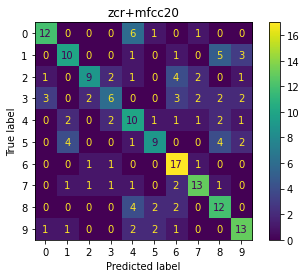

In [28]:
# Classifier training
SVM_dict = {}
for fm in feature_methods:
  clf = svm.SVC()
  clf.fit(train_features_dict[fm], Y_train)
  SVM_dict[fm] = clf


# Test and metric computation
SVM_metrics_dict = {}
for fm in feature_methods:
  # Feature extraction
  test_features = feature_extraction(L_test, fm)
  # Feature scaling
  scalers_dict[fm].transform(test_features)

  # Confusion Matrix Plot
  disp = plot_confusion_matrix(SVM_dict[fm], test_features, Y_test)
  disp.ax_.set_title(fm)
  plt.show()

  # Compute metrics
  y_pred = SVM_dict[fm].predict(test_features)
  metrics = compute_metrics (y_pred, Y_test)
  SVM_metrics_dict[fm] = metrics

classifiers.append('SVM')
metrics_dict['SVM'] = SVM_metrics_dict

### Random Forest Classifier

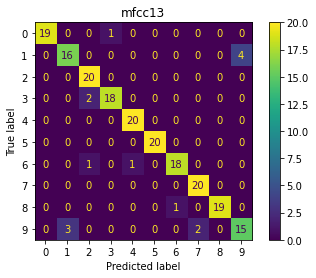

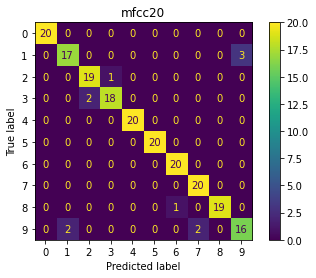

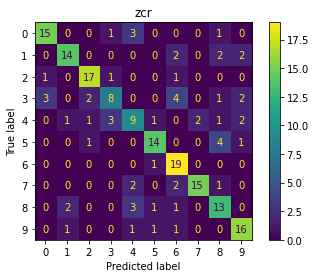

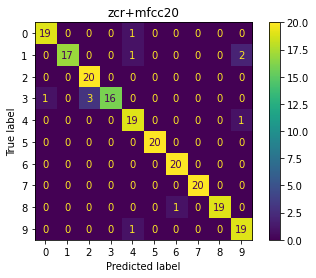

In [31]:
# Classifier training
RFC_dict = {}
for fm in feature_methods:
  clf = RandomForestClassifier(n_estimators=100, max_features="sqrt")
  clf.fit(train_features_dict[fm], Y_train)
  RFC_dict[fm] = clf


# Test and metric computation
RFC_metrics_dict = {}
for fm in feature_methods:
  # Feature extraction
  test_features = feature_extraction(L_test, fm)
  # Feature scaling
  scalers_dict[fm].transform(test_features)

  # Confusion Matrix Plot
  disp = plot_confusion_matrix(RFC_dict[fm], test_features, Y_test)
  disp.ax_.set_title(fm)
  plt.show()

  y_pred = RFC_dict[fm].predict(test_features)
  metrics = compute_metrics (y_pred, Y_test)
  RFC_metrics_dict[fm] = metrics

classifiers.append('RFC')
metrics_dict['RFC'] = RFC_metrics_dict

### Simple Neural Networks


Epoch 1/200
1800/1800 [==============================] - 0s 71us/step - loss: 2.3389 - accuracy: 0.0789
Epoch 2/200
1800/1800 [==============================] - 0s 12us/step - loss: 2.2881 - accuracy: 0.1261
Epoch 3/200
1800/1800 [==============================] - 0s 12us/step - loss: 2.2517 - accuracy: 0.1550
Epoch 4/200
1800/1800 [==============================] - 0s 12us/step - loss: 2.2147 - accuracy: 0.1978
Epoch 5/200
1800/1800 [==============================] - 0s 12us/step - loss: 2.1720 - accuracy: 0.2728
Epoch 6/200
1800/1800 [==============================] - 0s 13us/step - loss: 2.1174 - accuracy: 0.3072
Epoch 7/200
1800/1800 [==============================] - 0s 12us/step - loss: 2.0524 - accuracy: 0.3344
Epoch 8/200
1800/1800 [==============================] - 0s 12us/step - loss: 1.9780 - accuracy: 0.3667
Epoch 9/200
1800/1800 [==============================] - 0s 12us/step - loss: 1.8964 - accuracy: 0.3900
Epoch 10/200
1800/1800 [==============================] - 0s 13u

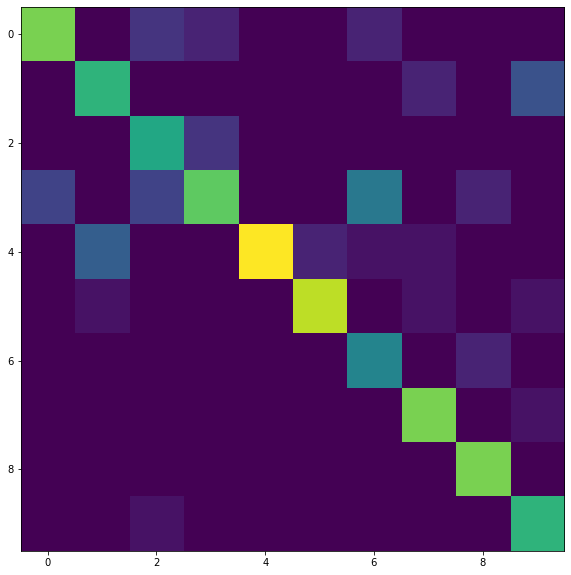

In [70]:
# Feature that we want to use
fm = "mfcc13"

ohe = OneHotEncoder()
ohe_y_train = ohe.fit_transform(Y_train.astype(int).reshape(-1, 1)).toarray()
ohe_y_test  = ohe.fit_transform(Y_test .astype(int).reshape(-1, 1)).toarray()

model = Sequential()
model.add(Dense(20, input_dim=13, activation='tanh'))
model.add(Dense(15, activation='tanh'))
model.add(Dense(12, activation='tanh'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_features_dict[fm], ohe_y_train, epochs=200, batch_size=128)

# Feature extraction
test_features = feature_extraction(X_test, fm)
# Feature scaling
scalers_dict[fm].transform(test_features)

y_pred = model.predict(test_features)

#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(ohe_y_test)):
    test.append(np.argmax(ohe_y_test[i]))

plt.imshow(confusion_matrix(pred, test))
metrics = compute_metrics(pred, test)

classifiers.append("NN")
metrics_dict['NN'] = {fm : metrics}

## Performance Evaluation

Here we can evaluate the performance of the classifiers using the metrics previously computed

In [21]:
for c in classifiers:
  print("========", c, "========")
  for fm in feature_methods:
    if metrics_dict.get(c) != None and metrics_dict.get(c).get(fm) != None:
      print("#", fm, "#")
      for m in metrics_dict[c][fm]:
        print("[{}]".format(m[0]))
        print("{}".format(m[1]))
  print("===========================\n")

======== SVM ========
# mfcc13 #
[Accuracy]
0.935
[ConfusionMatrix]
[[20  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 0  0 19  1  0  0  0  0  0  0]
 [ 1  0  2 17  0  0  0  0  0  0]
 [ 0  0  0  0 19  1  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  1  0 19  0]
 [ 0  2  0  0  0  1  0  3  0 14]]
# mfcc20 #
[Accuracy]
0.965
[ConfusionMatrix]
[[20  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  0 19  1  0  0  0  0  0  0]
 [ 1  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  1  0 19  0]
 [ 0  1  0  0  0  0  0  3  0 16]]
# zcr #
[Accuracy]
0.56
[ConfusionMatrix]
[[12  0  0  0  6  1  0  1  0  0]
 [ 0 10  0  0  1  0  1  0  5  3]
 [ 1  0  9  2  1  0  4  2  0  1]
 [ 3  0  2  7  0  0  3  1  2  2]
 [ 0  2  0  2 10  1  1  1  2  1]
 [ 0  3  0  0  1 

## Google Dataset Results

In [71]:
fm = 'mfcc13'
clf = 'NN'

# Y_GD labels are ints
y_test = np.char.mod('%d', Y_GD)

ohe_y_test  = ohe.fit_transform(Y_GD .astype(int).reshape(-1, 1)).toarray()

# Feature extraction
test_features = feature_extraction(X_GD, fm)
# Feature scaling
scalers_dict[fm].transform(test_features)

# Confusion Matrix Plot
plt.rcParams['figure.figsize'] = [10, 10]
#y_pred = RFC_dict[fm].predict(test_features)

y_pred = model.predict(test_features)

pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(ohe_y_test)):
    test.append(np.argmax(ohe_y_test[i]))
    
print(accuracy_score(test, pred))
#disp = plot_confusion_matrix(RFC_dict[fm], test_features, y_test)
#disp.ax_.set_title(fm)
#plt.show()

0.3874757035409448


## Style

In [0]:
import matplotlib as mpl
COLOR = 'darkgrey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR